## Prepareing the Data

In [1]:
import string

letters = string.ascii_letters + " .,;'-"
n_letters = len(letters)

language_names = {}
languages = []
n_languages = 0

In [2]:
import glob

def find_files(path):
    return glob.glob(path)

In [3]:
import unicodedata

def unicode_2_ascii(unicode_string):
    ascii_string = ""
    
    for char in unicodedata.normalize("NFD", unicode_string):
        if unicodedata.category(char) != "Mn" and char in letters:
            ascii_string += char
            
    return ascii_string

In [4]:
def read_names(file_name):
    with open(file_name, encoding="utf-8") as f:
        file_data = f.read()
        
    names = file_data.strip().split('\n')
    names = [unicode_2_ascii(name) for name in names]
    
    return names

In [5]:
import os

for file_name in find_files("data/names/*.txt"):
    language = os.path.splitext(os.path.basename(file_name))[0]
    names = read_names(file_name)
    
    language_names[language] = names
    
languages = list(language_names.keys())
n_languages = len(languages)

## Creating the Network

In [6]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_languages + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_languages + input_size + hidden_size, output_size)
        
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, language, input_, hidden):
        input_combined = torch.cat((language, input_, hidden), 1)
        
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        
        output_combined = torch.cat((hidden, output), 1)
        
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [7]:
rnn = RNN(n_letters, 128, n_letters)

## Training

### Preparing for Training

In [8]:
import random

def random_choice(list_):
    return list_[random.randint(0, len(list_) - 1)]

In [9]:
def random_training_pair():
    language = random_choice(languages)
    name = random_choice(language_names[language])
    
    return language, name

In [10]:
def language_tensor(language):
    language_idx = languages.index(language)
    
    tensor = torch.zeros(1, n_languages)
    tensor[0][language_idx] = 1
    
    return tensor

In [11]:
def input_tensor(input_):
    tensor = torch.zeros(len(input_), 1, n_letters)
    
    for i in range(len(input_)):
        char = input_[i]
        
        tensor[i][0][letters.index(char)] = 1
        
    return tensor

In [12]:
def target_tensor(name):
    letter_idxs = [letters.index(name[i]) for i in range(1, len(name))]
    letter_idxs.append(n_letters - 1)  # EOS
    
    return torch.tensor(letter_idxs, dtype=torch.long).unsqueeze_(-1)

In [13]:
def random_training_example():
    language, name = random_training_pair()
    
    language = language_tensor(language)
    input_name = input_tensor(name)
    target_name = target_tensor(name)
    
    return language, input_name, target_name

### Training the Network
In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

In [14]:
n_iters = 100_000

print_every = 5_000
plot_every = 500
losses = []

In [15]:
criterion = nn.NLLLoss()

In [16]:
import torch.optim as optim

optimizer = optim.SGD(rnn.parameters(), lr=0.005)

In [17]:
def train(language_tensor, input_line_tensor, target_line_tensor):    
    hidden = rnn.init_hidden()
    
    rnn.zero_grad()
    
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(language_tensor, input_line_tensor[i], hidden)
        
        loss_ = criterion(output, target_line_tensor[i])
        loss += loss_
        
    loss.backward()
    
    optimizer.step()
    
    return output, loss.item() / input_line_tensor.size()[0]

In [18]:
import time

def time_since(since):
    now = time.time()
    
    total_secs = now - since
    
    minutes = int(total_secs / 60)
    seconds = total_secs - minutes * 60
    
    return f"{minutes:.0f}m {seconds:.0f}s"

In [19]:
import matplotlib.pyplot as plt

def plot_losses(losses):
    plt.plot(losses)
    plt.show()

0m 13s (5000 5%) 2.6762
0m 28s (10000 10%) 1.4358
0m 43s (15000 15%) 4.2015
0m 59s (20000 20%) 2.1646
1m 13s (25000 25%) 1.5673
1m 27s (30000 30%) 2.6783
1m 40s (35000 35%) 1.8770
1m 54s (40000 40%) 2.4832
2m 8s (45000 45%) 3.1461
2m 21s (50000 50%) 2.6114
2m 35s (55000 55%) 2.6303
2m 49s (60000 60%) 2.8389
3m 4s (65000 65%) 2.3217
3m 19s (70000 70%) 1.8398
3m 33s (75000 75%) 3.0189
3m 47s (80000 80%) 1.8619
4m 2s (85000 85%) 2.9715
4m 17s (90000 90%) 2.2235
4m 32s (95000 95%) 1.8178
4m 46s (100000 100%) 1.8213


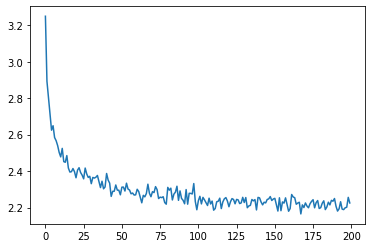

In [20]:
total_loss = 0
start = time.time()

for iteration in range(1, n_iters + 1):
    language, input_, target = random_training_example()
    
    output, loss = train(language, input_, target)
    
    if iteration % print_every == 0:
        print(f"{time_since(start)} ({iteration:.0f} {iteration / n_iters:.0%}) {loss:.4f}")
    
    total_loss += loss
    if iteration % plot_every == 0:
        losses.append(total_loss / plot_every)
        total_loss = 0
        
plot_losses(losses)

## Sampling the Network

In [21]:
max_length = 20

In [22]:
def sample(language, start_letter="A"):
    with torch.no_grad():
        language = language_tensor(language)
        input_ = input_tensor(start_letter)
        
        output_name = start_letter
        
        hidden = rnn.init_hidden()
                
        for i in range(max_length):
            output, hidden = rnn(language, input_[0], hidden)
            
            _, top_idxs = output.topk(1)
            top_idx = top_idxs[0][0]
            
            if top_idx == n_letters - 1:
                break
            else:
                letter = letters[top_idx]
                output_name += letter
            
            input_ = input_tensor(letter)
            
        return output_name

In [23]:
def samples(language, start_letters="ABC"):
    for start_letter in start_letters:
        print(sample(language, start_letter))
    print()

In [24]:
samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Roskov
Urishav
Sakov

Gring
Echerter
Romer

Salo
Parrai
Abara

Cha
Han
Ina

